# **Melanoma Detection Assignment**

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Import Libraries

In [28]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


In [29]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir = "/kaggle/input/melanoma-detection-isic/Skin cancer ISIC The International Skin Imaging Collaboration"
data_dir_train = pathlib.Path(os.path.join(data_dir, "Train"))
data_dir_test = pathlib.Path(os.path.join(data_dir, "Test"))

In [30]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)
     

2239
118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset
Define some parameters for the loader:

In [31]:
batch_size = 32
img_height = 180
img_width = 180
     

Use 80% of the images for training, and 20% for validation.

In [32]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               seed=123, 
                                                               validation_split=0.2, 
                                                               subset = "training",
                                                               label_mode='categorical',
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size
                                                              )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [33]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2, 
                                                             subset = "validation",
                                                             label_mode='categorical',
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size
                                                            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [34]:

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)
     

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

In [35]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

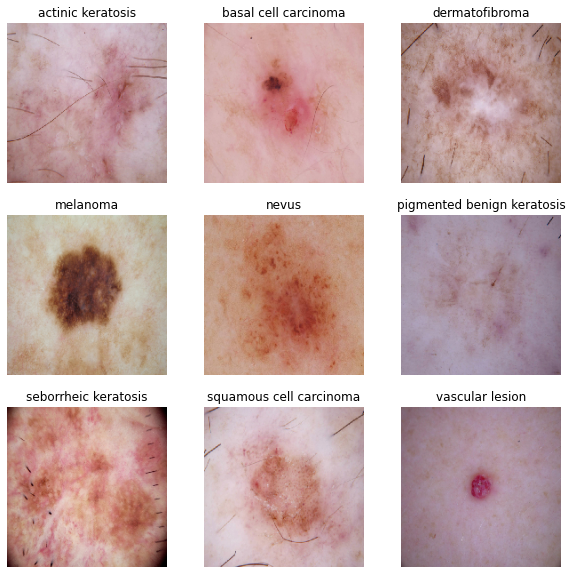

In [36]:
#Visualize image 
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.title(c)
    plt.axis("off")
    plt.imshow(load_img(path_list[0],target_size=(180,180)))

The **image_batch** is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The **label_batch** is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()** keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [37]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use **layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1)**. The RGB channel values are in the [0,255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0,1]

In [38]:
def create_basic_model():
    # Initilize a Sequential model object
    model = Sequential()

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Second Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.5))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(128, activation="relu"))

    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_basic_model()

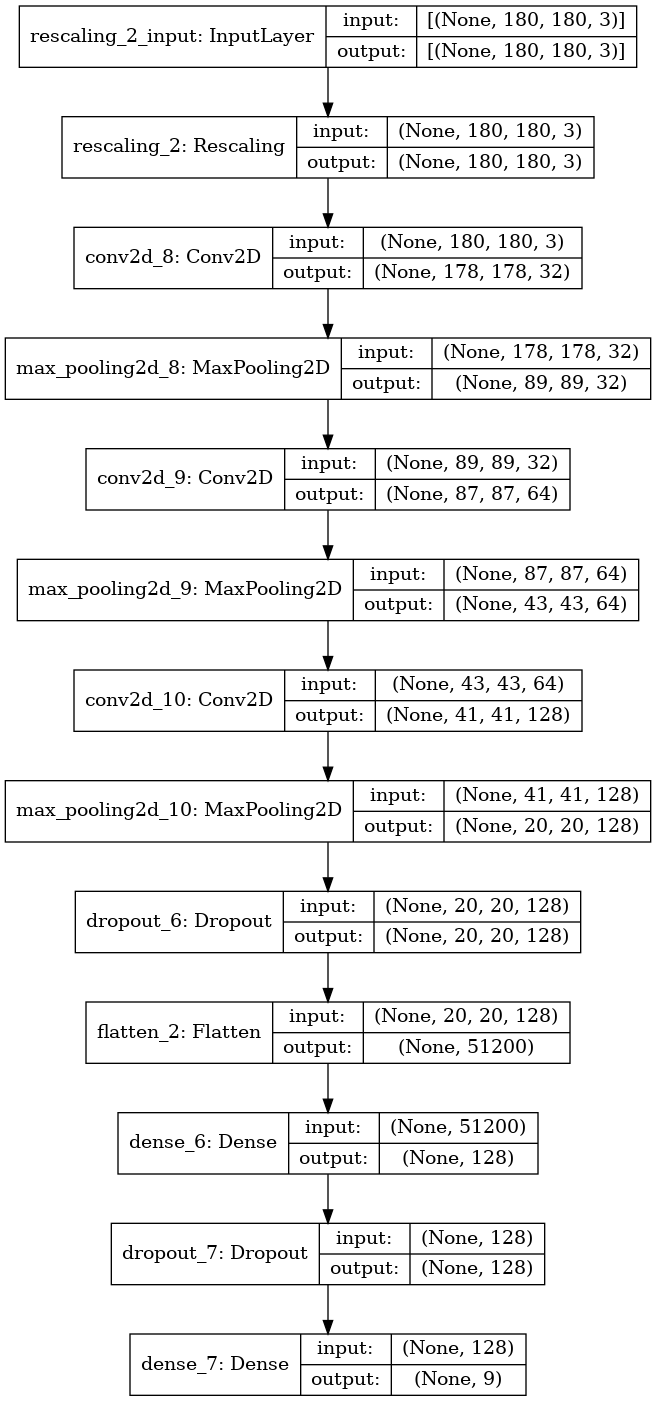

In [39]:
# vizualizing the model 
plot_model(model, to_file='melanoma_model_plot1.png', show_shapes=True, show_layer_names=True)

### Compile the model

Choose an appropirate optimiser and loss function for model training

In [42]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

# #Stop training when a monitored metric has stopped improving.
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 41, 41, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 20, 20, 128)      

### Train the model

In [44]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
56/56 [==============================] - 14s 68ms/step - loss: 2.0113 - accuracy: 0.2478 - val_loss: 1.8792 - val_accuracy: 0.2975
Epoch 2/30
56/56 [==============================] - 1s 21ms/step - loss: 1.7391 - accuracy: 0.3588 - val_loss: 1.6514 - val_accuracy: 0.4407
Epoch 3/30
56/56 [==============================] - 1s 21ms/step - loss: 1.6254 - accuracy: 0.4129 - val_loss: 1.5780 - val_accuracy: 0.4609
Epoch 4/30
56/56 [==============================] - 1s 21ms/step - loss: 1.5608 - accuracy: 0.4509 - val_loss: 1.4847 - val_accuracy: 0.5034
Epoch 5/30
56/56 [==============================] - 1s 22ms/step - loss: 1.5052 - accuracy: 0.4749 - val_loss: 1.4871 - val_accuracy: 0.4966
Epoch 6/30
56/56 [==============================] - 1s 23ms/step - loss: 1.4267 - accuracy: 0.5151 - val_loss: 1.4624 - val_accuracy: 0.4944
Epoch 7/30
56/56 [==============================] - 1s 21ms/step - loss: 1.3683 - accuracy: 0.5246 - val_loss: 1.4401 - val_accuracy: 0.5257
Epoch 8/30
5

### Visualizing training results

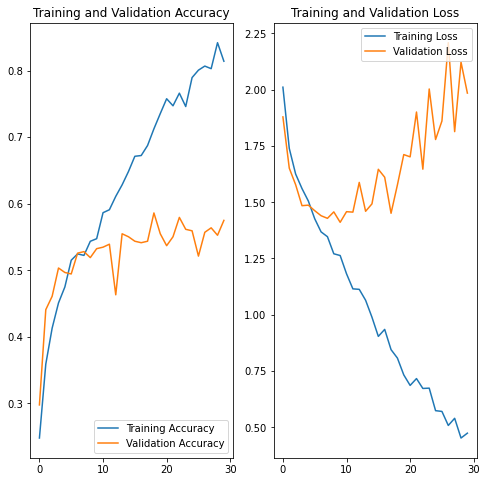

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=30
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**Findings on the first base model**
1. The training accuracy of the base model is around 86% and that of validation is 54%.
2. The model is clearly overfitting as seen in the plot, there is considerate difference between the train and validation accuracy and also the loss.

In [46]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

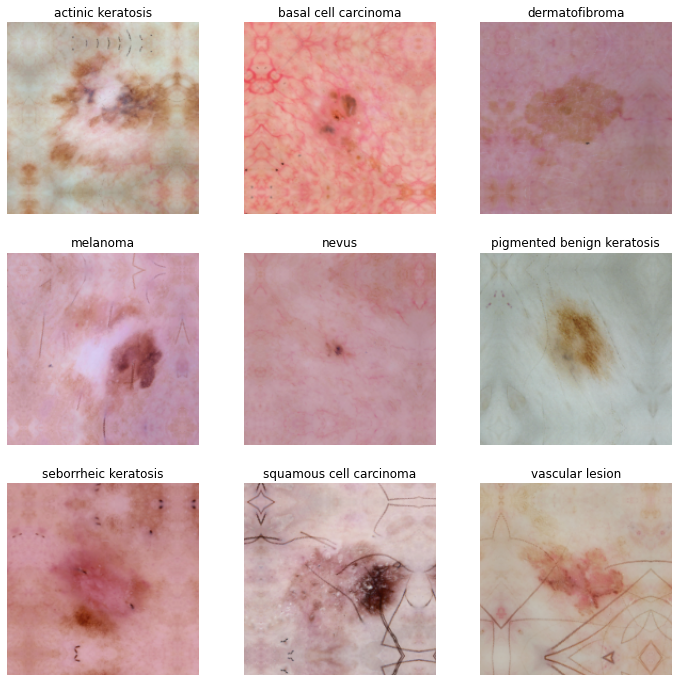

In [47]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

### Create the model, compile and train the model

In [48]:
def create_augmentation_model(data_augmentation):
    # Initilize a Sequential model object
    model = Sequential([data_augmentation])

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #Second Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Third Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #Fourth Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Fivth Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.25))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(512, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(256, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(128, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_augmentation_model(data_augmentation)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 41, 41, 64)       

### Compiling and Training the model

In [49]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 22ms/step - loss: 2.0743 - accuracy: 0.1892 - val_loss: 2.0416 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 1s 20ms/step - loss: 2.0371 - accuracy: 0.1992 - val_loss: 2.0232 - val_accuracy: 0.2058
Epoch 3/30
56/56 [==============================] - 1s 20ms/step - loss: 2.0121 - accuracy: 0.2059 - val_loss: 1.9080 - val_accuracy: 0.2416
Epoch 4/30
56/56 [==============================] - 1s 20ms/step - loss: 1.9173 - accuracy: 0.2695 - val_loss: 1.9822 - val_accuracy: 0.2394
Epoch 5/30
56/56 [==============================] - 1s 20ms/step - loss: 1.8022 - accuracy: 0.3080 - val_loss: 1.8101 - val_accuracy: 0.2729
Epoch 6/30
56/56 [==============================] - 1s 20ms/step - loss: 1.7131 - accuracy: 0.3577 - val_loss: 1.6798 - val_accuracy: 0.3736
Epoch 7/30
56/56 [==============================] - 1s 19ms/step - loss: 1.7013 - accuracy: 0.3789 - val_loss: 1.6821 - val_accuracy: 0.4206
Epoch 8/30
56

### Visualizing the results

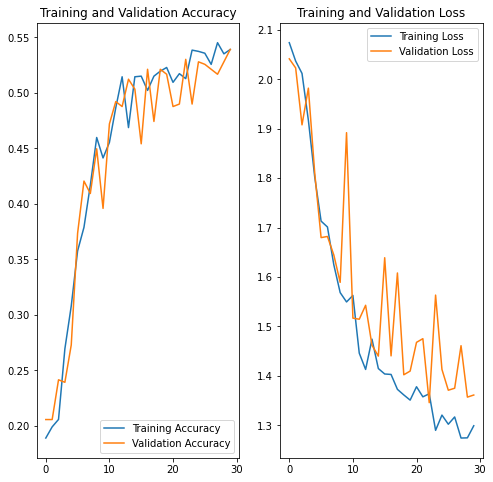

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings from Second model**
1. Using Data Augmentation, clearly the problem of overfitting has been solved. But there is no improvement in accuracy.
2. Model is underfitting and increasing the number of epochs might improve the accuracy.

**Todo: Find the distribution of classes in the training dataset.
Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

In [51]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,pigmented benign keratosis,462
1,melanoma,438
2,vascular lesion,139
3,actinic keratosis,114
4,squamous cell carcinoma,181
5,basal cell carcinoma,376
6,seborrheic keratosis,77
7,dermatofibroma,95
8,nevus,357


In [52]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
label_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
original_df = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(original_df.items()),columns = ['Path','Label'])

**Todo: Write your findings here:**
- Which class has the least number of samples?
    **seborrheic keratosis**

- Which classes dominate the data in terms proportionate number of samples?
    **pigmented benign keratosis** and
    **melanoma**

**Todo: Rectify the class imbalance**

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [54]:
path_to_training_dataset= os.path.join(data_dir, "Train")
path_to_output_dataset = "/kaggle/working/balanced_melanoma_data"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i),output_directory=os.path.join(path_to_output_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93E47A8B10>: 100%|██████████| 500/500 [00:16<00:00, 29.96 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9475457F10>: 100%|██████████| 500/500 [00:15<00:00, 31.90 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93E3DFC950>: 100%|██████████| 500/500 [00:17<00:00, 29.25 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/melanoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3872x2592 at 0x7F9475422110>: 100%|██████████| 500/500 [01:23<00:00,  5.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F93E3E84E90>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93E3EFC150>: 100%|██████████| 500/500 [00:16<00:00, 29.52 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F93E4D86ED0>: 100%|██████████| 500/500 [00:38<00:00, 12.94 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/squamous cell carcinoma.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9450474B50>: 100%|██████████| 500/500 [00:16<00:00, 29.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/balanced_melanoma_data/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F93E4D8A490>: 100%|██████████| 500/500 [00:16<00:00, 30.56 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
data_dir_train_balanced = pathlib.Path(path_to_output_dataset)
image_count_train = len(list(data_dir_train_balanced.glob('*/*.jpg')))
print(image_count_train)

Lets see the distribution of augmented data after adding new images to the original training data.

In [56]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train_balanced, '*', '*.jpg'))]
label_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train_balanced, '*', '*.jpg'))]

dataframe_dict_new = dict(zip(path_list_new,label_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [57]:
new_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

**Todo:** Train the model on the data created using Augmentor

In [58]:
batch_size = 32
img_height = 180
img_width = 180

In [59]:
data_dir_train=os.path.join(data_dir_train_balanced)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [60]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


In [61]:
def create_balanced_dataset_model():
    # Initilize a Sequential model object
    model = Sequential()

    #Normalize the pixel values between (0,1)
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

    #First Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    #Second Convolution layer
    model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Third Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())
    
    #Fourth Convolution layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Fivth Convolution layer
    model.add(layers.Conv2D(128, kernel_size=(3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.BatchNormalization())

    #Dropout layer with 50% of the units to drop
    model.add(layers.Dropout(0.25))

    #Flatten layer
    model.add(layers.Flatten())

    #Dense layer
    model.add(layers.Dense(512, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(256, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))
    
    #Dense layer
    model.add(layers.Dense(128, activation="relu"))
    #Dropout layer
    model.add(layers.Dropout(0.25))

    #Dense layer with softmax activation function
    model.add(layers.Dense(len(class_names), activation="softmax"))
    
    return model

model = create_balanced_dataset_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 89, 89, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 43, 32)       

In [62]:
#compiling the model

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [63]:
#train the model

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 23s 98ms/step - loss: 1.7155 - accuracy: 0.3590 - val_loss: 2.8512 - val_accuracy: 0.1217
Epoch 2/30
225/225 [==============================] - 22s 93ms/step - loss: 1.4185 - accuracy: 0.4531 - val_loss: 1.9650 - val_accuracy: 0.2583
Epoch 3/30
225/225 [==============================] - 22s 97ms/step - loss: 1.2282 - accuracy: 0.5401 - val_loss: 1.1752 - val_accuracy: 0.5494
Epoch 4/30
225/225 [==============================] - 22s 94ms/step - loss: 1.0653 - accuracy: 0.6043 - val_loss: 1.3215 - val_accuracy: 0.5533
Epoch 5/30
225/225 [==============================] - 22s 96ms/step - loss: 0.9110 - accuracy: 0.6611 - val_loss: 1.3682 - val_accuracy: 0.5500
Epoch 6/30
225/225 [==============================] - 22s 96ms/step - loss: 0.7883 - accuracy: 0.7103 - val_loss: 1.4995 - val_accuracy: 0.4989
Epoch 7/30
225/225 [==============================] - 22s 93ms/step - loss: 0.7027 - accuracy: 0.7374 - val_loss: 1.4445 - val_accuracy:

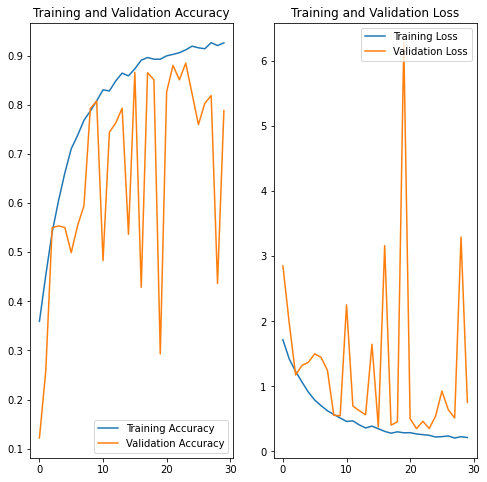

In [64]:
# visualize the model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

Accuracy has increased with rebalancing the data. 
However,model is overfitting. 
